## Imports and Configurations

In [1]:
import numpy as np
import pandas as pd
from typing import List, Any, Tuple
import matplotlib.pyplot as plt

In [2]:
np.random.seed(4)

## Dataset

In [3]:
data = pd.read_csv('titanic.train.real_valued.csv')
data.drop("PassengerId", axis=1, inplace=True)

* PassengerId: Passenger ID.
* Pclass: Ticket class. A proxy for socio-economic status (SES). 1 = 1st class (upper), 2 = 2nd class
(middle), 3 = 3rd class (lower)
* Sex: Sex.0 = male, 1 = female
* Age: Age in years. Age is fractional if less than 1.
* SibSp: # of siblings / spouses aboard the Titanic. The dataset defines family relations in this
way... Sibling = brother, sister, stepbrother, stepsister. Spouse = husband, wife (mistresses and
fiancés were ignored)
* Parch: # of parents / children aboard the Titanic. The dataset defines family relations in this
way... Parent = mother, father. Child = daughter, son, stepdaughter, stepson. Some children
travelled only with a nanny, therefore parch=0 for them.
* Ticket: Ticket number.
* Fare: Passenger fare.
* Embarked: Port of Embarkation. 0 = Cherbourg, 1 = Queenstown, 2 = Southampton,
* Survived: Target variable (class label). 0 = Not Survived, 1 = Survived.

In [4]:
# Count the occurrence of each ticket
ticket_counts = data['Ticket'].value_counts()

# Tickets appearing more than once are marked as 1, others as 0
data['Common_ticket'] = data['Ticket'].map(lambda x: 1 if ticket_counts[x] > 1 else 0)
data.drop("Ticket", axis=1, inplace=True)

In [5]:
data.dtypes

Pclass             int64
Sex                int64
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Embarked           int64
Survived           int64
Common_ticket      int64
dtype: object

In [6]:
data.nunique()

Pclass             3
Sex                2
Age               76
SibSp              6
Parch              7
Fare             220
Embarked           3
Survived           2
Common_ticket      2
dtype: int64

## Utils

In [7]:
def accuracy(y_true: List[Any], y_pred: List[Any]) -> float:
    return np.mean(np.array(y_true) == np.array(y_pred))

In [8]:
def train_test_split(data: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    test = data.sample(frac=test_size)
    train = data.drop(test.index)
    return train.reset_index(drop=True), test.reset_index(drop=True)

## Decision Tree

In [9]:
class Node:
    def __init__(self, data: pd.DataFrame = None, depth: int = 0, 
                 split_attribute: str = None, split_value: Any = None, 
                 is_greater_split: bool = False) -> None:
        self.data = data
        self.depth = depth
        self.split_attribute = split_attribute
        self.split_value = split_value
        self.is_greater_split = is_greater_split
        self.children: List[Node] = []
        self.is_leaf: bool = False
        self._prediction = None

    def add_child(self, child: 'Node') -> None:
        self.children.append(child)
        self.is_leaf = False

    def remove_child(self, child: 'Node') -> None:
        self.children.remove(child)
        if not self.children:
            self.is_leaf = True

    @property
    def prediction(self) -> Any:
        return self._prediction
    
    @prediction.setter
    def prediction(self, value: Any) -> None:
        if self.is_leaf:
            self._prediction = value
        else:
            raise ValueError('Cannot set prediction for non-leaf node')

In [10]:
class DecisionTree:
    def __init__(self, max_depth: int = 8) -> None:
        self.root: 'Node' = None
        self.max_depth: int = max_depth

    @property
    def max_depth(self) -> int:
        return self._max_depth

    @max_depth.setter
    def max_depth(self, value: Any) -> None:
        if isinstance(value, int):
            if value < 1:
                raise ValueError('max_depth must be at least 1')
            if value >= 1000:
                self._max_depth = 1000  # Limit due to Python's recursion limit
            else:
                self._max_depth = value
        elif value == 'unlimited':
            self._max_depth = 1000  # Limit due to Python's recursion limit
        else:
            raise ValueError('max_depth must be an integer or "unlimited"')

    @staticmethod
    def impurity(data: pd.DataFrame, target: str) -> float:
        entropy = 0
        for value in data[target].unique():
            p = len(data[data[target] == value]) / len(data)
            entropy -= p * np.log2(p)
        return entropy

    @staticmethod
    def information_gain(data: pd.DataFrame, attribute: str, target: str) -> float:
        gain = DecisionTree.impurity(data, target)
        for value in data[attribute].unique():
            subset = data[data[attribute] == value]
            gain -= len(subset) / len(data) * DecisionTree.impurity(subset, target)
        return gain

    @staticmethod
    def find_best_threshold(data: pd.DataFrame, attribute: str, target: str) -> tuple:
        best_gain = -float('inf')
        best_threshold = None
        sorted_values = sorted(data[attribute].unique())
        for i in range(len(sorted_values) - 1):
            threshold = (sorted_values[i] + sorted_values[i + 1]) / 2
            subset_less = data[data[attribute] <= threshold]
            subset_greater = data[data[attribute] > threshold]
            gain = DecisionTree.impurity(data, target) - (len(subset_less) / len(data) * DecisionTree.impurity(subset_less, target) + len(subset_greater) / len(data) * DecisionTree.impurity(subset_greater, target))
            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold
        return best_gain, best_threshold

    def fit(self, data: pd.DataFrame, target: str, data_valid: pd.DataFrame = None, verbose: bool = False, early_stopping: bool = False) -> None:
        if early_stopping and data_valid is None:
            raise ValueError("Validation data must be provided for early stopping.")

        self.best_tree = None
        self.best_accuracy = 0
        self.no_improvement_steps = 0
        self.early_stopping = early_stopping

        try:
            self.root = self._build_tree(data, target, 0, data_valid, verbose, early_stopping)
        except StopIteration:
            if verbose:
                print("Early stopping triggered, ending fitting process.")
                
            self.root = self.best_tree


    def _build_tree(self, data: pd.DataFrame, target: str, depth: int, data_valid=None, verbose=False, early_stopping=False) -> Node:
        if len(data[target].unique()) == 1 or depth == self.max_depth:
            leaf = Node(data, depth)
            leaf.is_leaf = True
            leaf.prediction = data[target].mode()[0]  # Most common target value
            if verbose:
                print(f"Depth {depth}: Leaf node with prediction {leaf.prediction}")
            
            # Early Stopping Check at this leaf
            if early_stopping and data_valid is not None:
                self._check_early_stopping(data_valid, target, leaf, depth, verbose)

            return leaf
        
        best_gain = -float('inf')
        best_attribute = None
        best_threshold = None

        for attribute in data.columns:
            if attribute != target:
                if data[attribute].dtype == 'float64':
                    gain, threshold = self.find_best_threshold(data, attribute, target)
                    if verbose:
                        print(f"Depth {depth}: Checking attribute '{attribute}' with threshold {threshold}, Information Gain: {gain}")
                    if gain > best_gain:
                        best_gain = gain
                        best_attribute = attribute
                        best_threshold = threshold
                elif data[attribute].dtype == 'int64':
                    gain = self.information_gain(data, attribute, target)
                    if verbose:
                        print(f"Depth {depth}: Checking attribute '{attribute}', Information Gain: {gain}")
                    if gain > best_gain:
                        best_gain = gain
                        best_attribute = attribute
                        best_threshold = None
        
        if best_gain == -float('inf'):
            leaf = Node(data, depth)
            leaf.is_leaf = True
            leaf.prediction = data[target].mode()[0]
            if verbose:
                print(f"Depth {depth}: Leaf node with prediction {leaf.prediction}")
                
            return leaf

        if data[best_attribute].dtype == 'float64':
            root = Node(data, depth, best_attribute, best_threshold)
            left_data = data[data[best_attribute] <= best_threshold]
            right_data = data[data[best_attribute] > best_threshold]

            if verbose:
                print(f"Depth {depth}: Creating left child node with threshold <= {best_threshold}")
            root.add_child(self._build_tree(left_data, target, depth + 1, data_valid, verbose, early_stopping))
            if verbose:
                print(f"Depth {depth}: Creating right child node with threshold > {best_threshold}")
            root.add_child(self._build_tree(right_data, target, depth + 1, data_valid, verbose, early_stopping))
        elif data[best_attribute].dtype == 'int64':
            root = Node(data, depth, split_attribute=best_attribute)
            for value in data[best_attribute].unique():
                subset = data[data[best_attribute] == value]
                if verbose:
                    print(f"Depth {depth}: Creating child node for {best_attribute} == {value}")
                root.add_child(self._build_tree(subset, target, depth + 1, data_valid, verbose, early_stopping))

        # Early Stopping Check after building children
        if early_stopping and data_valid is not None:
            self._check_early_stopping(data_valid, target, root, depth, verbose)
        
        return root
    
    def _check_early_stopping(self, data_valid, target, current_tree, depth, verbose): # TODO: Early stopping do not always work, try to debug it
        current_accuracy = accuracy(data_valid[target], self.predict(data_valid, current_tree))
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.best_tree = current_tree
            self.no_improvement_steps = 0
        else:
            self.no_improvement_steps += 1
            if self.no_improvement_steps >= 5:
                if verbose:
                    print(f"Depth {depth}: Early stopping triggered. No improvement for 5 steps.")
                raise StopIteration
            
    def predict(self, data: pd.DataFrame, altenative_node: 'Node' = None) -> list:
        predictions = []

        for instance in data.to_dict(orient='records'):
            node = self.root if altenative_node is None else altenative_node
            while not node.is_leaf:
                split_value = instance[node.split_attribute]

                if node.data[node.split_attribute].dtype == 'float64':
                    if split_value <= node.split_value:
                        node = node.children[0]  # Go to left child
                    else:
                        node = node.children[1]  # Go to right child
                elif node.data[node.split_attribute].dtype == 'int64':
                    child_found = False
                    for child in node.children:
                        if child.data[node.split_attribute].values[0] == split_value:
                            node = child
                            child_found = True
                            break
                    if not child_found:
                        # TODO: Handle unseen values
                        break

            predictions.append(node.prediction)

        return predictions
    
    def print_tree(self, node=None, indent=""):
        if node is None:
            node = self.root

        if node.is_leaf:
            print(indent + "Leaf Node: Predicts " + str(node.prediction))
        else:
            if node.split_value is not None:
                print(indent + f"Node: {node.split_attribute} <= {node.split_value}")
                self.print_tree(node.children[0], indent + "\t")
                print(indent + f"Node: {node.split_attribute} > {node.split_value}")
                self.print_tree(node.children[1], indent + "\t")
            else:
                for child in node.children:
                    print(indent + f"Node: {node.split_attribute} == {child.data[node.split_attribute].values[0]}")
                    self.print_tree(child, indent + "\t")

    def __repr__(self) -> str:
        return 'DecisionTree with max depth ' + str(self.max_depth)

## Evaluation

#### Display tree

In [11]:
train, test = train_test_split(data, 0.2)

In [12]:
dt = DecisionTree(max_depth=3)
dt.fit(data=train, target='Survived', verbose=True)
dt

Depth 0: Checking attribute 'Pclass', Information Gain: 0.10026109974769273
Depth 0: Checking attribute 'Sex', Information Gain: 0.20891544634353543
Depth 0: Checking attribute 'Age' with threshold 8.5, Information Gain: 0.019630443987942003
Depth 0: Checking attribute 'SibSp', Information Gain: 0.017839411856530797
Depth 0: Checking attribute 'Parch', Information Gain: 0.03501296371086839
Depth 0: Checking attribute 'Fare' with threshold 15.64585, Information Gain: 0.0713816550658688
Depth 0: Checking attribute 'Embarked', Information Gain: 0.0314825472531568
Depth 0: Checking attribute 'Common_ticket', Information Gain: 0.024519492215460903
Depth 0: Creating child node for Sex == 0
Depth 1: Checking attribute 'Pclass', Information Gain: 0.05202457989176831
Depth 1: Checking attribute 'Sex', Information Gain: 0.0
Depth 1: Checking attribute 'Age' with threshold 13.0, Information Gain: 0.05517160504648033
Depth 1: Checking attribute 'SibSp', Information Gain: 0.016805925193863452
Depth

DecisionTree with max depth 3

In [13]:
dt.print_tree()

Node: Sex == 0
	Node: Age <= 13.0
		Node: SibSp == 0
			Leaf Node: Predicts 1
		Node: SibSp == 1
			Leaf Node: Predicts 1
		Node: SibSp == 4
			Leaf Node: Predicts 0
		Node: SibSp == 2
			Leaf Node: Predicts 1
		Node: SibSp == 5
			Leaf Node: Predicts 0
		Node: SibSp == 3
			Leaf Node: Predicts 0
	Node: Age > 13.0
		Node: Pclass == 3
			Leaf Node: Predicts 0
		Node: Pclass == 2
			Leaf Node: Predicts 0
		Node: Pclass == 1
			Leaf Node: Predicts 0
Node: Sex == 1
	Node: Pclass == 3
		Node: Age <= 38.5
			Leaf Node: Predicts 1
		Node: Age > 38.5
			Leaf Node: Predicts 0
	Node: Pclass == 1
		Node: Parch == 2
			Leaf Node: Predicts 1
		Node: Parch == 1
			Leaf Node: Predicts 1
		Node: Parch == 0
			Leaf Node: Predicts 1
	Node: Pclass == 2
		Node: Age <= 23.5
			Leaf Node: Predicts 1
		Node: Age > 23.5
			Leaf Node: Predicts 1


#### Performance without pruning

In [14]:
dt = DecisionTree(max_depth="unlimited")
dt.fit(data=train, target='Survived')
dt

DecisionTree with max depth 1000

In [15]:
y_pred_no_pruning = dt.predict(test)

accuracy_no_pruning = accuracy(test['Survived'], y_pred_no_pruning)
accuracy_no_pruning

0.7552447552447552

#### Performance with early stopping

In [16]:
dt = DecisionTree(max_depth="unlimited")
dt.fit(data=train, target='Survived', early_stopping=True, data_valid=test)
dt

DecisionTree with max depth 1000

In [17]:
y_pred_early_stopping = dt.predict(test)

accuracy_early_stopping = accuracy(test['Survived'], y_pred_no_pruning)
accuracy_early_stopping

0.7552447552447552

#### Performance for different max_depths

In [18]:
# Initialize a dictionary to store accuracy scores for different max depths
accuracy_scores_depth = {}

# Loop over different values of max_depth
for max_depth in range(1, 100, 2):  # Adjust the range as needed
    # Train DecisionTree with varying max depth
    dt = DecisionTree(max_depth=max_depth)
    dt.fit(data=train, target='Survived')

    # Predictions
    y_pred = dt.predict(test)

    # Accuracy
    accuracy_score = accuracy(test['Survived'], y_pred)
    
    # Store the accuracy score
    accuracy_scores_depth[max_depth] = accuracy_score

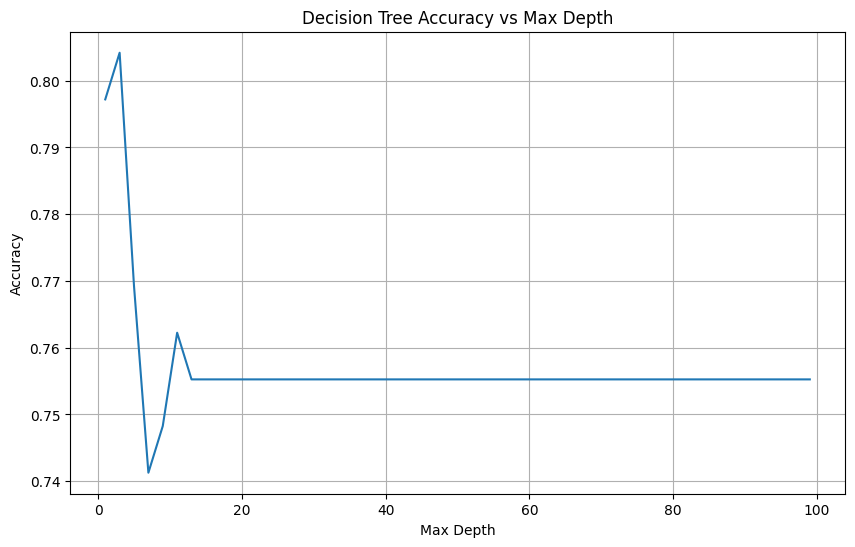

In [19]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(accuracy_scores_depth.keys(), accuracy_scores_depth.values())
plt.title('Decision Tree Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Interpretation of the Decision Tree Accuracy vs Max Depth Plot

The plot showing Decision Tree Accuracy vs Max Depth suggests a complex relationship between the maximum depth of the decision tree and its accuracy. From the graph, we can observe a sharp increase in accuracy as the depth increases initially, which peaks quite early. This peak is typically where the model has learned enough patterns from the data to make good predictions. After reaching this peak, the accuracy sharply decreases, suggesting the model might be starting to overfit the training data. Overfitting is a modeling error that occurs when a model is too complex, capturing noise in the dataset rather than the underlying pattern.

As the max depth increases beyond a certain point, the accuracy seems to level off. This plateau indicates that increasing the complexity of the model (by increasing `max_depth`) does not lead to further gains in accuracy on the test data. The model's performance does not significantly degrade, likely due to the simplicity of the data or the presence of mechanisms that prevent overfitting, such as pruning within the Decision Tree algorithm. 

Overall, the optimal `max_depth` appears to be at the early peak. It is the point of complexity where the model is sufficiently learned but not overfitted to the training data.

#### Performance for different train/test size

In [20]:
# Initialize a dictionary to store accuracy scores
accuracy_scores = {}

# Test sizes from 0.1 to 0.9
for test_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # Split data
    train, test = train_test_split(data, test_size=test_size)

    # Train DecisionTree
    dt = DecisionTree(max_depth=3)
    dt.fit(data=train, target='Survived')

    # Predictions
    y_pred = dt.predict(test)

    # Accuracy
    accuracy_score = accuracy(test['Survived'], y_pred)
    
    # Store the accuracy score
    accuracy_scores[test_size] = accuracy_score

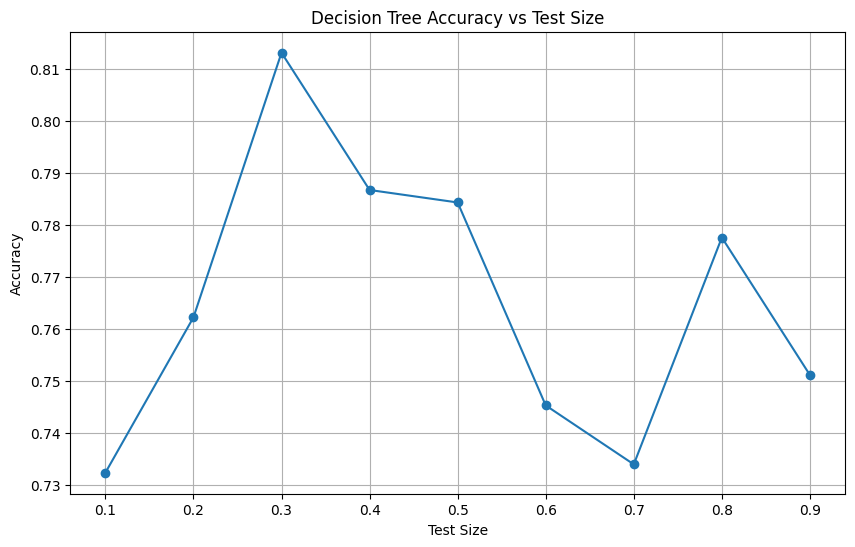

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(accuracy_scores.keys(), accuracy_scores.values(), marker='o')
plt.title('Decision Tree Accuracy vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Interpretation of the Decision Tree Accuracy vs Test Size Plot

The second plot illustrates the variation in accuracy of the Decision Tree model as the test size increases from 0.1 to 0.9. The accuracy shows a somewhat inverse-V-shaped relationship with the test size, initially increasing with the test size and then declining before slightly recovering towards the end.

A possible explanation for the initial increase is that a smaller test set may not be representative of the overall data distribution, leading to higher variability in accuracy scores. As the test size increases, the test data becomes more representative, leading to a more accurate assessment of the model's performance.

The subsequent decline in accuracy as the test size increases beyond a certain point might be due to the reduction in training data size. With less data to learn from, the model may not capture the complexity of the data well, leading to worse performance on the test set.

The slight recovery in accuracy at high test sizes is somewhat counterintuitive, as we would typically expect the model's performance to continue declining as the test size approaches the size of the dataset. However, this could be due to random fluctuations in the data, specific characteristics of the test data, or randomness in the model training process.

In practice, a test size between 0.2 and 0.3 is often a good balance between having a model trained on sufficient data and having a robust test set to evaluate the model.